In [2]:
import os
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"

In [3]:
import numpy as np
import cv2
import pandas as pd
from tqdm.notebook import tqdm 
from sklearn.model_selection import train_test_split
import tensorflow
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam 

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision 
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

import time

In [4]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [5]:
original_fake_paths = []

for dirname, _, filenames in tqdm(os.walk('/Users/rahultorlapati/Downloads/Semester 4/DATA 606/Datasets/untitled folder/fake')):
    for filename in filenames:
        original_fake_paths.append([os.path.join(dirname, filename)])

In [6]:
len(original_fake_paths)

10001

In [7]:
train_fake_paths, test_fake_paths = train_test_split(original_fake_paths, test_size=2000, random_state=2019)

fake_train_df = pd.DataFrame(train_fake_paths, columns=['filename'])
fake_train_df['class'] = 'FAKE'

fake_test_df = pd.DataFrame(test_fake_paths, columns=['filename'])
fake_test_df['class'] = 'FAKE'

In [8]:
original_real_paths = []

for dirname, _, filenames in tqdm(os.walk('/Users/rahultorlapati/Downloads/Semester 4/DATA 606/Datasets/untitled folder/real')):
    for filename in filenames:
        original_real_paths.append([os.path.join(dirname, filename)])

In [9]:
original_real_paths = original_real_paths[0:10001]

In [10]:
train_real_paths, test_real_paths = train_test_split(original_real_paths, test_size=2000, random_state=2019)

real_train_df = pd.DataFrame(train_real_paths, columns=['filename'])
real_train_df['class'] = 'REAL'

real_test_df = pd.DataFrame(test_real_paths, columns=['filename'])
real_test_df['class'] = 'REAL'

In [11]:
train_df = pd.concat([real_train_df, fake_train_df])
test_df = pd.concat([real_test_df, fake_test_df])

In [12]:
df = pd.concat([train_df, test_df])

In [13]:
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_gen = datagen.flow_from_dataframe(
    df,
    target_size=(224, 224),
    batch_size=64,
    class_mode='binary',
    subset='training'
)

val_gen = datagen.flow_from_dataframe(
    df,
    target_size=(224, 224),
    batch_size=64,
    class_mode='binary',
    subset='validation'
)

Found 16001 validated image filenames belonging to 2 classes.
Found 4000 validated image filenames belonging to 2 classes.


/opt/anaconda3/lib/python3.7/site-packages/keras_preprocessing/image/dataframe_iterator.py:273: UserWarning: Found 1 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  .format(n_invalid, x_col)


In [13]:
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, Dropout, BatchNormalization, GlobalAveragePooling2D

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout

model = tensorflow.keras.Sequential()
model.add(Conv2D(64, kernel_size=3, activation='relu', input_shape=(224,224,3)))
model.add(Conv2D(32, kernel_size=3, activation='relu'))
model.add(Flatten())
model.add(Dense(2, activation='softmax'))

In [15]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 220, 220, 32)      18464     
_________________________________________________________________
flatten (Flatten)            (None, 1548800)           0         
_________________________________________________________________
dense (Dense)                (None, 2)                 3097602   
Total params: 3,117,858
Trainable params: 3,117,858
Non-trainable params: 0
_________________________________________________________________


In [17]:
train_history_step1 = model.fit_generator(
    train_gen,
    validation_data=val_gen,
    steps_per_epoch=len(train_gen),
    validation_steps=len(val_gen),
    epochs = 7,
)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/7
251/251 [==============================] - 710s 3s/step - loss: 0.2197 - accuracy: 0.9721 - val_loss: 0.0525 - val_accuracy: 0.9815
Epoch 2/7
251/251 [==============================] - 718s 3s/step - loss: 0.0015 - accuracy: 0.9996 - val_loss: 0.0082 - val_accuracy: 0.9977
Epoch 3/7
251/251 [==============================] - 763s 3s/step - loss: 0.0011 - accuracy: 0.9997 - val_loss: 0.0068 - val_accuracy: 0.9977
Epoch 4/7
251/251 [==============================] - 802s 3s/step - loss: 9.2370e-05 - accuracy: 1.0000 - val_loss: 0.0066 - val_accuracy: 0.9977
Epoch 5/7
251/251 [==============================] - 776s 3s/step - loss: 1.8363e-05 - accuracy: 1.0000 - val_loss: 0.0049 - val_accuracy: 0.9987
Epoch 6/7
251/251 [==============================] - 795s 3s/step - loss: 1.0603e-05 - accuracy: 1.0000 - val_loss: 0.0052 - val_accuracy: 0.9985
Epoch 7/7
251/251 [==============================] - 772s 3s

In [18]:
model1 = tensorflow.keras.Sequential()
model1.add(Conv2D(32, kernel_size=(3, 3),activation='relu',input_shape=(224,224,3)))
model1.add(Conv2D(64, (3, 3), activation='relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Dropout(0.25))
model1.add(Flatten())
model1.add(Dense(128, activation='relu'))
model1.add(Dropout(0.5))
model1.add(Dense(2, activation='softmax'))

In [19]:
model1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [20]:
model1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 220, 220, 64)      18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 110, 110, 64)      0         
_________________________________________________________________
dropout (Dropout)            (None, 110, 110, 64)      0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 774400)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               99123328  
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)              

In [21]:
train_history_step2 = model1.fit_generator(
    train_gen,
    validation_data=val_gen,
    steps_per_epoch=len(train_gen),
    validation_steps=len(val_gen),
    epochs=7
)

Epoch 1/7
251/251 [==============================] - 746s 3s/step - loss: 0.4098 - accuracy: 0.9687 - val_loss: 0.0179 - val_accuracy: 0.9930
Epoch 2/7
251/251 [==============================] - 750s 3s/step - loss: 0.0031 - accuracy: 0.9993 - val_loss: 0.0143 - val_accuracy: 0.9960
Epoch 3/7
251/251 [==============================] - 671s 3s/step - loss: 0.0021 - accuracy: 0.9992 - val_loss: 0.0024 - val_accuracy: 0.9987
Epoch 4/7
251/251 [==============================] - 716s 3s/step - loss: 0.0040 - accuracy: 0.9989 - val_loss: 0.0080 - val_accuracy: 0.9973
Epoch 5/7
251/251 [==============================] - 739s 3s/step - loss: 0.0048 - accuracy: 0.9985 - val_loss: 0.0096 - val_accuracy: 0.9962
Epoch 6/7
251/251 [==============================] - 723s 3s/step - loss: 0.0050 - accuracy: 0.9985 - val_loss: 0.0185 - val_accuracy: 0.9933
Epoch 7/7
251/251 [==============================] - 730s 3s/step - loss: 0.0014 - accuracy: 0.9997 - val_loss: 0.0051 - val_accuracy: 0.9977


In [22]:
densenet = DenseNet121(
    weights='imagenet',
    include_top=False,
    input_shape=(224,224,3)
)

for layer in densenet.layers:
    layer.trainable = False

In [23]:
def build_model(densenet):
    model = tensorflow.keras.Sequential()
    model.add(densenet)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))
    
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))
    
    model.add(layers.Dense(1, activation='sigmoid'))
    
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(lr=0.0005),
        metrics=['accuracy']
    )
    
    return model

In [24]:
model2 = build_model(densenet)
model2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Model)          (None, 7, 7, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1024)              4096      
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               262400    
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)              

In [25]:
train_history_step3 = model2.fit_generator(
    train_gen,
    validation_data=val_gen,
    steps_per_epoch=len(train_gen),
    validation_steps=len(val_gen),
    epochs=7
)

Epoch 1/7
251/251 [==============================] - 869s 3s/step - loss: 0.0672 - accuracy: 0.9743 - val_loss: 0.0094 - val_accuracy: 0.9987
Epoch 2/7
251/251 [==============================] - 840s 3s/step - loss: 0.0118 - accuracy: 0.9968 - val_loss: 0.0020 - val_accuracy: 0.9992
Epoch 3/7
251/251 [==============================] - 829s 3s/step - loss: 0.0089 - accuracy: 0.9971 - val_loss: 9.3182e-04 - val_accuracy: 0.9998
Epoch 4/7
251/251 [==============================] - 823s 3s/step - loss: 0.0042 - accuracy: 0.9988 - val_loss: 2.6615e-04 - val_accuracy: 1.0000
Epoch 5/7
251/251 [==============================] - 829s 3s/step - loss: 0.0039 - accuracy: 0.9989 - val_loss: 3.0940e-04 - val_accuracy: 1.0000
Epoch 6/7
251/251 [==============================] - 829s 3s/step - loss: 0.0035 - accuracy: 0.9990 - val_loss: 2.0069e-04 - val_accuracy: 1.0000
Epoch 7/7
251/251 [==============================] - 831s 3s/step - loss: 0.0040 - accuracy: 0.9988 - val_loss: 2.5472e-04 - val_acc

In [26]:
resnet = keras.applications.resnet50.ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(224,224,3)
)

for layer in resnet.layers:
    layer.trainable = False

In [27]:
def build_model(resnet):
    model = tensorflow.keras.Sequential()
    model.add(resnet)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))
    
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))
    
    model.add(layers.Dense(1, activation='sigmoid'))
    
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(lr=0.0005),
        metrics=['accuracy']
    )
    
    return model

In [28]:
model3 = build_model(resnet)
model3.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 2048)              8192      
_________________________________________________________________
dropout_4 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               524544    
_________________________________________________________________
batch_normalization_3 (Batch (None, 256)               1024      
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)              

In [29]:
train_history_step4 = model3.fit_generator(
    train_gen,
    validation_data=val_gen,
    steps_per_epoch=len(train_gen),
    validation_steps=len(val_gen),
    epochs=7
)

Epoch 1/7
251/251 [==============================] - 577s 2s/step - loss: 0.3237 - accuracy: 0.8700 - val_loss: 1.1707 - val_accuracy: 0.0428
Epoch 2/7
251/251 [==============================] - 579s 2s/step - loss: 0.2130 - accuracy: 0.9184 - val_loss: 0.5699 - val_accuracy: 0.6975
Epoch 3/7
251/251 [==============================] - 575s 2s/step - loss: 0.1944 - accuracy: 0.9236 - val_loss: 0.1792 - val_accuracy: 0.9335
Epoch 4/7
251/251 [==============================] - 578s 2s/step - loss: 0.1717 - accuracy: 0.9317 - val_loss: 0.1660 - val_accuracy: 0.9327
Epoch 5/7
251/251 [==============================] - 574s 2s/step - loss: 0.1619 - accuracy: 0.9383 - val_loss: 0.1199 - val_accuracy: 0.9525
Epoch 6/7
251/251 [==============================] - 581s 2s/step - loss: 0.1474 - accuracy: 0.9433 - val_loss: 0.1372 - val_accuracy: 0.9442
Epoch 7/7
251/251 [==============================] - 578s 2s/step - loss: 0.1600 - accuracy: 0.9391 - val_loss: 0.1152 - val_accuracy: 0.9525


In [14]:
xception = tensorflow.keras.applications.Xception(
    include_top=False,
    weights="imagenet",
    input_shape=(224,224,3)
)

for layer in xception.layers:
    layer.trainable = False

In [15]:
def build_model(xception):
    model = tensorflow.keras.Sequential()
    model.add(xception)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))
    
    model.add(layers.Dense(1, activation='sigmoid'))
    
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(lr=0.0005),
        metrics=['accuracy']
    )
    
    return model

In [16]:
model4 = build_model(xception)
model4.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 7, 7, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 2048)              8192      
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 2048)              8192      
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2

In [17]:
train_history_step5 = model4.fit_generator(
    train_gen,
    validation_data=val_gen,
    steps_per_epoch=len(train_gen),
    validation_steps=len(val_gen),
    epochs=7
)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/7
251/251 [==============================] - 535s 2s/step - loss: 0.2106 - accuracy: 0.9149 - val_loss: 0.1659 - val_accuracy: 0.9655
Epoch 2/7
251/251 [==============================] - 521s 2s/step - loss: 0.0683 - accuracy: 0.9759 - val_loss: 0.0316 - val_accuracy: 0.9930
Epoch 3/7
251/251 [==============================] - 518s 2s/step - loss: 0.0450 - accuracy: 0.9844 - val_loss: 0.0170 - val_accuracy: 0.9952
Epoch 4/7
251/251 [==============================] - 518s 2s/step - loss: 0.0391 - accuracy: 0.9869 - val_loss: 0.0119 - val_accuracy: 0.9973
Epoch 5/7
251/251 [==============================] - 546s 2s/step - loss: 0.0338 - accuracy: 0.9882 - val_loss: 0.0111 - val_accuracy: 0.9962
Epoch 6/7
251/251 [==============================] - 792s 3s/step - loss: 0.0328 - accuracy: 0.9881 - val_loss: 0.0091 - val_accuracy: 0.9970
Epoch 7/7
251/251 [==============================] - 564s 2s/step - loss

In [91]:
data = train_history_step5.history['val_loss']

In [92]:
data

[0.16594697535037994,
 0.031580112874507904,
 0.01696157455444336,
 0.01188588049262762,
 0.011069701053202152,
 0.00906087551265955,
 0.008440283127129078]

In [64]:
l1 = [0.0525, 0.0082, 0.0068, 0.0066, 0.0049, 0.0052, 0.0047]
l2 = [0.0179, 0.0143, 0.0024, 0.0080, 0.0096, 0.0185, 0.0051]
l3 = [0.0094, 0.0020, 9.3183e-04, 2.6615e-04, 3.0940e-04, 2.0069e-04, 2.5472e-04]
l4 = [1.1707, 0.5699, 0.1792, 0.1660, 0.1199, 0.1372, 0.1152]

In [93]:
df =pd.DataFrame([l1,l2,l3,l4,data])

In [97]:
df1.columns = ['SimpleCNN', 'ComplexCNN', 'DenseNet121', 'ResNet50', 'Xecption']

In [98]:
df1

,SimpleCNN,ComplexCNN,DenseNet121,ResNet50,Xecption
0,0.0525,0.0179,0.009400,1.1707,0.165947
1,0.0082,0.0143,0.002000,0.5699,0.031580
2,0.0068,0.0024,0.000932,0.1792,0.016962
3,0.0066,0.0080,0.000266,0.1660,0.011886
4,0.0049,0.0096,0.000309,0.1199,0.011070
5,0.0052,0.0185,0.000201,0.1372,0.009061
6,0.0047,0.0051,0.000255,0.1152,0.008440


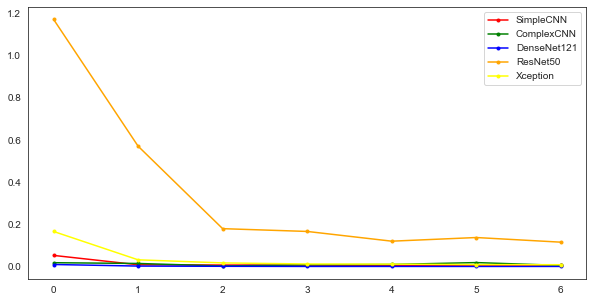

In [106]:
sns.set_style("white")
fig, ax = plt.subplots(figsize=(10,5))
plt.plot(df1.index, df1.SimpleCNN, "o-", ms=3,
            color="r", label='SimpleCNN')
plt.plot(df1.index, df1.ComplexCNN, "o-", ms=3,
            color="g", label='ComplexCNN')
plt.plot(df1.index, df1.DenseNet121, "o-", ms=3,
            color="blue", label='DenseNet121')
plt.plot(df1.index, df1.ResNet50, "o-", ms=3,
            color="orange", label='ResNet50')
plt.plot(df1.index, df1.Xecption, "o-", ms=3,
            color="yellow", label='Xception')
ax.legend()